In [1]:
import sys
import os

# Step 1: Get current directory 
current_directory = os.getcwd()        # '/home/bear-b/users/jshi008/IvyProjects/FIDLA/train_WaLeF_models'

# Step 2: Get path of parent directory (one level up)
parent_directory = os.path.dirname(current_directory)    # '/home/bear-b/users/jshi008/IvyProjects/FIDLA'

# Step 3: Append parent directory to sys.path
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from math import sqrt
from tensorflow import keras
from tensorflow.keras import Model, Input, layers
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


from preprocess.BaselinePrerocess import baseline_process
from baselines.transformer import transformer_encoder

2023-08-01 22:03:06.433006: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-01 22:03:07.764087: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9

In [5]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [6]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 96, 16) (9634, 96, 16) (19268, 96, 16) (77069, 96) (9634, 96) (19268, 96)


### Model

In [7]:
# ===== model parameters ======
input_shape = train_X_mask.shape[1:]
head_size = 64*2
ff_dim = 64
num_transformer_blocks = 1
num_heads = 1
mlp_units = 32
dropout = 0.4
mlp_dropout = 0.3
masked_value = 1e-10
learning_rate = 5e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 500
EPOCHS = 3000
BATCH = 512

In [8]:
model = transformer_encoder(input_shape,
                            head_size=head_size, 
                            num_heads=num_heads, 
                            ff_dim=ff_dim, 
                            num_transformer_blocks=num_transformer_blocks, 
                            mlp_units=mlp_units, 
                            dropout=dropout, 
                            mlp_dropout=mlp_dropout,
                            masked_value=masked_value
                           )
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 16)]             0         []                            
                                                                                                  
 masking (Masking)           (None, 96, 16)               0         ['input_1[0][0]']             
                                                                                                  
 multi_head_attention (Mult  (None, 96, 16)               8592      ['masking[0][0]',             
 iHeadAttention)                                                     'masking[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 96, 16)               0         ['multi_head_attention[0][

2023-08-01 22:03:14.851153: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1


                                                                                                  
 dense_1 (Dense)             (None, 96, 16)               1040      ['dropout_1[0][0]']           
                                                                                                  
 layer_normalization_1 (Lay  (None, 96, 16)               32        ['dense_1[0][0]']             
 erNormalization)                                                                                 
                                                                                                  
 tf.__operators__.add_1 (TF  (None, 96, 16)               0         ['layer_normalization_1[0][0]'
 OpLambda)                                                          , 'tf.__operators__.add[0][0]'
                                                                    ]                             
                                                                                                  
 dense_2 (

In [9]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('../saved_models/WaLeF_transformer.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True,
                     
                    )


model.fit(train_X_mask, train_ws_y,
          validation_data=(test_X_mask, test_ws_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc]
         )

Epoch 1/3000


2023-08-01 22:03:23.286963: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9e74047fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-01 22:03:23.287013: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-08-01 22:03:23.296528: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-01 22:03:23.520597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-01 22:03:23.881186: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_mae improved from inf to 0.07961, saving model to ../saved_models/WaLeF_transformer1.h5
151/151 - 10s - loss: 0.4177 - mae: 0.4522 - val_loss: 0.0104 - val_mae: 0.0796 - 10s/epoch - 65ms/step
Epoch 2/3000


/aul/homes/jshi008/miniconda3/envs/tf213/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_mae improved from 0.07961 to 0.06007, saving model to ../saved_models/WaLeF_transformer1.h5
151/151 - 3s - loss: 0.0506 - mae: 0.1758 - val_loss: 0.0058 - val_mae: 0.0601 - 3s/epoch - 20ms/step
Epoch 3/3000

Epoch 3: val_mae improved from 0.06007 to 0.05827, saving model to ../saved_models/WaLeF_transformer1.h5
151/151 - 3s - loss: 0.0249 - mae: 0.1234 - val_loss: 0.0054 - val_mae: 0.0583 - 3s/epoch - 20ms/step
Epoch 4/3000

Epoch 4: val_mae improved from 0.05827 to 0.05026, saving model to ../saved_models/WaLeF_transformer1.h5
151/151 - 3s - loss: 0.0158 - mae: 0.0983 - val_loss: 0.0040 - val_mae: 0.0503 - 3s/epoch - 20ms/step
Epoch 5/3000

Epoch 5: val_mae improved from 0.05026 to 0.04578, saving model to ../saved_models/WaLeF_transformer1.h5
151/151 - 3s - loss: 0.0112 - mae: 0.0826 - val_loss: 0.0033 - val_mae: 0.0458 - 3s/epoch - 20ms/step
Epoch 6/3000

Epoch 6: val_mae improved from 0.04578 to 0.04132, saving model to ../saved_models/WaLeF_transformer1.h5
151/151 - 

151/151 - 3s - loss: 5.2682e-04 - mae: 0.0169 - val_loss: 9.5683e-04 - val_mae: 0.0254 - 3s/epoch - 19ms/step
Epoch 43/3000

Epoch 43: val_mae did not improve from 0.02446
151/151 - 3s - loss: 5.1339e-04 - mae: 0.0166 - val_loss: 9.0398e-04 - val_mae: 0.0247 - 3s/epoch - 19ms/step
Epoch 44/3000

Epoch 44: val_mae did not improve from 0.02446
151/151 - 3s - loss: 4.9708e-04 - mae: 0.0164 - val_loss: 9.2645e-04 - val_mae: 0.0252 - 3s/epoch - 19ms/step
Epoch 45/3000

Epoch 45: val_mae did not improve from 0.02446
151/151 - 3s - loss: 4.9411e-04 - mae: 0.0163 - val_loss: 9.2463e-04 - val_mae: 0.0251 - 3s/epoch - 19ms/step
Epoch 46/3000

Epoch 46: val_mae did not improve from 0.02446
151/151 - 3s - loss: 4.9472e-04 - mae: 0.0163 - val_loss: 9.1192e-04 - val_mae: 0.0250 - 3s/epoch - 19ms/step
Epoch 47/3000

Epoch 47: val_mae did not improve from 0.02446
151/151 - 3s - loss: 4.8928e-04 - mae: 0.0162 - val_loss: 9.4210e-04 - val_mae: 0.0254 - 3s/epoch - 19ms/step
Epoch 48/3000

Epoch 48: val_m

Epoch 85/3000

Epoch 85: val_mae improved from 0.01575 to 0.01566, saving model to ../saved_models/WaLeF_transformer1.h5
151/151 - 3s - loss: 3.0557e-04 - mae: 0.0123 - val_loss: 4.1454e-04 - val_mae: 0.0157 - 3s/epoch - 20ms/step
Epoch 86/3000

Epoch 86: val_mae did not improve from 0.01566
151/151 - 3s - loss: 3.1228e-04 - mae: 0.0125 - val_loss: 4.7582e-04 - val_mae: 0.0168 - 3s/epoch - 19ms/step
Epoch 87/3000

Epoch 87: val_mae did not improve from 0.01566
151/151 - 3s - loss: 3.0723e-04 - mae: 0.0123 - val_loss: 4.7831e-04 - val_mae: 0.0167 - 3s/epoch - 19ms/step
Epoch 88/3000

Epoch 88: val_mae did not improve from 0.01566
151/151 - 3s - loss: 3.0800e-04 - mae: 0.0124 - val_loss: 4.3757e-04 - val_mae: 0.0162 - 3s/epoch - 20ms/step
Epoch 89/3000

Epoch 89: val_mae did not improve from 0.01566
151/151 - 3s - loss: 3.0304e-04 - mae: 0.0122 - val_loss: 4.9280e-04 - val_mae: 0.0169 - 3s/epoch - 19ms/step
Epoch 90/3000

Epoch 90: val_mae did not improve from 0.01566
151/151 - 3s - loss

Epoch 131/3000

Epoch 131: val_mae did not improve from 0.01450
151/151 - 3s - loss: 2.5241e-04 - mae: 0.0109 - val_loss: 4.7859e-04 - val_mae: 0.0167 - 3s/epoch - 19ms/step
Epoch 132/3000

Epoch 132: val_mae did not improve from 0.01450
151/151 - 3s - loss: 2.4989e-04 - mae: 0.0109 - val_loss: 4.0980e-04 - val_mae: 0.0155 - 3s/epoch - 19ms/step
Epoch 133/3000

Epoch 133: val_mae did not improve from 0.01450
151/151 - 3s - loss: 2.4804e-04 - mae: 0.0108 - val_loss: 3.6486e-04 - val_mae: 0.0145 - 3s/epoch - 19ms/step
Epoch 134/3000

Epoch 134: val_mae did not improve from 0.01450
151/151 - 3s - loss: 2.4786e-04 - mae: 0.0108 - val_loss: 4.3419e-04 - val_mae: 0.0161 - 3s/epoch - 19ms/step
Epoch 135/3000

Epoch 135: val_mae did not improve from 0.01450
151/151 - 3s - loss: 2.4752e-04 - mae: 0.0108 - val_loss: 3.7571e-04 - val_mae: 0.0149 - 3s/epoch - 19ms/step
Epoch 136/3000

Epoch 136: val_mae did not improve from 0.01450
151/151 - 3s - loss: 2.4778e-04 - mae: 0.0108 - val_loss: 4.5220e-

Epoch 178/3000

Epoch 178: val_mae did not improve from 0.01397
151/151 - 3s - loss: 2.2259e-04 - mae: 0.0101 - val_loss: 3.3641e-04 - val_mae: 0.0140 - 3s/epoch - 19ms/step
Epoch 179/3000

Epoch 179: val_mae did not improve from 0.01397
151/151 - 3s - loss: 2.2284e-04 - mae: 0.0101 - val_loss: 3.8276e-04 - val_mae: 0.0151 - 3s/epoch - 19ms/step
Epoch 180/3000

Epoch 180: val_mae did not improve from 0.01397
151/151 - 3s - loss: 2.2221e-04 - mae: 0.0101 - val_loss: 3.8717e-04 - val_mae: 0.0151 - 3s/epoch - 19ms/step
Epoch 181/3000

Epoch 181: val_mae did not improve from 0.01397
151/151 - 3s - loss: 2.2079e-04 - mae: 0.0101 - val_loss: 3.6200e-04 - val_mae: 0.0146 - 3s/epoch - 19ms/step
Epoch 182/3000

Epoch 182: val_mae did not improve from 0.01397
151/151 - 3s - loss: 2.2079e-04 - mae: 0.0101 - val_loss: 3.4221e-04 - val_mae: 0.0142 - 3s/epoch - 19ms/step
Epoch 183/3000

Epoch 183: val_mae did not improve from 0.01397
151/151 - 3s - loss: 2.2005e-04 - mae: 0.0101 - val_loss: 4.1460e-


Epoch 225: val_mae did not improve from 0.01397
151/151 - 3s - loss: 2.1111e-04 - mae: 0.0098 - val_loss: 4.1497e-04 - val_mae: 0.0160 - 3s/epoch - 19ms/step
Epoch 226/3000

Epoch 226: val_mae did not improve from 0.01397
151/151 - 3s - loss: 2.1076e-04 - mae: 0.0098 - val_loss: 4.0298e-04 - val_mae: 0.0154 - 3s/epoch - 19ms/step
Epoch 227/3000

Epoch 227: val_mae did not improve from 0.01397
151/151 - 3s - loss: 2.1157e-04 - mae: 0.0098 - val_loss: 3.7090e-04 - val_mae: 0.0148 - 3s/epoch - 19ms/step
Epoch 228/3000

Epoch 228: val_mae did not improve from 0.01397
151/151 - 3s - loss: 2.1153e-04 - mae: 0.0098 - val_loss: 3.6323e-04 - val_mae: 0.0147 - 3s/epoch - 19ms/step
Epoch 229/3000

Epoch 229: val_mae did not improve from 0.01397
151/151 - 3s - loss: 2.1135e-04 - mae: 0.0098 - val_loss: 3.3358e-04 - val_mae: 0.0140 - 3s/epoch - 19ms/step
Epoch 230/3000

Epoch 230: val_mae did not improve from 0.01397
151/151 - 3s - loss: 2.1130e-04 - mae: 0.0098 - val_loss: 3.7426e-04 - val_mae: 0

151/151 - 3s - loss: 2.0615e-04 - mae: 0.0097 - val_loss: 4.3255e-04 - val_mae: 0.0165 - 3s/epoch - 19ms/step
Epoch 273/3000

Epoch 273: val_mae did not improve from 0.01397
151/151 - 3s - loss: 2.0642e-04 - mae: 0.0097 - val_loss: 4.1806e-04 - val_mae: 0.0160 - 3s/epoch - 19ms/step
Epoch 274/3000

Epoch 274: val_mae did not improve from 0.01397
151/151 - 3s - loss: 2.0519e-04 - mae: 0.0097 - val_loss: 3.4897e-04 - val_mae: 0.0144 - 3s/epoch - 19ms/step
Epoch 275/3000

Epoch 275: val_mae did not improve from 0.01397
151/151 - 3s - loss: 2.0555e-04 - mae: 0.0097 - val_loss: 3.8221e-04 - val_mae: 0.0150 - 3s/epoch - 19ms/step
Epoch 276/3000

Epoch 276: val_mae did not improve from 0.01397
151/151 - 3s - loss: 2.0635e-04 - mae: 0.0097 - val_loss: 3.3589e-04 - val_mae: 0.0140 - 3s/epoch - 19ms/step
Epoch 277/3000

Epoch 277: val_mae did not improve from 0.01397
151/151 - 3s - loss: 2.0661e-04 - mae: 0.0097 - val_loss: 4.4875e-04 - val_mae: 0.0165 - 3s/epoch - 19ms/step
Epoch 278/3000

Epoc

Epoch 320/3000

Epoch 320: val_mae did not improve from 0.01397
151/151 - 3s - loss: 2.0145e-04 - mae: 0.0096 - val_loss: 4.2220e-04 - val_mae: 0.0158 - 3s/epoch - 19ms/step
Epoch 321/3000

Epoch 321: val_mae did not improve from 0.01397
151/151 - 3s - loss: 2.0166e-04 - mae: 0.0096 - val_loss: 3.7015e-04 - val_mae: 0.0148 - 3s/epoch - 19ms/step
Epoch 322/3000

Epoch 322: val_mae did not improve from 0.01397
151/151 - 3s - loss: 2.0195e-04 - mae: 0.0096 - val_loss: 3.9130e-04 - val_mae: 0.0152 - 3s/epoch - 19ms/step
Epoch 323/3000

Epoch 323: val_mae did not improve from 0.01397
151/151 - 3s - loss: 2.0120e-04 - mae: 0.0096 - val_loss: 3.8544e-04 - val_mae: 0.0152 - 3s/epoch - 19ms/step
Epoch 324/3000

Epoch 324: val_mae did not improve from 0.01397
151/151 - 3s - loss: 2.0093e-04 - mae: 0.0096 - val_loss: 4.0221e-04 - val_mae: 0.0154 - 3s/epoch - 19ms/step
Epoch 325/3000

Epoch 325: val_mae did not improve from 0.01397
151/151 - 3s - loss: 2.0094e-04 - mae: 0.0096 - val_loss: 3.6509e-

Epoch 367/3000

Epoch 367: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.9787e-04 - mae: 0.0095 - val_loss: 3.6364e-04 - val_mae: 0.0145 - 3s/epoch - 19ms/step
Epoch 368/3000

Epoch 368: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.9756e-04 - mae: 0.0095 - val_loss: 3.8466e-04 - val_mae: 0.0150 - 3s/epoch - 19ms/step
Epoch 369/3000

Epoch 369: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.9762e-04 - mae: 0.0095 - val_loss: 3.5062e-04 - val_mae: 0.0144 - 3s/epoch - 19ms/step
Epoch 370/3000

Epoch 370: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.9840e-04 - mae: 0.0096 - val_loss: 4.9637e-04 - val_mae: 0.0174 - 3s/epoch - 19ms/step
Epoch 371/3000

Epoch 371: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.9795e-04 - mae: 0.0095 - val_loss: 4.0646e-04 - val_mae: 0.0157 - 3s/epoch - 19ms/step
Epoch 372/3000

Epoch 372: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.9834e-04 - mae: 0.0095 - val_loss: 4.5808e-


Epoch 414: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.9492e-04 - mae: 0.0095 - val_loss: 4.5100e-04 - val_mae: 0.0163 - 3s/epoch - 19ms/step
Epoch 415/3000

Epoch 415: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.9432e-04 - mae: 0.0095 - val_loss: 3.4661e-04 - val_mae: 0.0143 - 3s/epoch - 19ms/step
Epoch 416/3000

Epoch 416: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.9416e-04 - mae: 0.0095 - val_loss: 3.8437e-04 - val_mae: 0.0149 - 3s/epoch - 19ms/step
Epoch 417/3000

Epoch 417: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.9467e-04 - mae: 0.0095 - val_loss: 3.8434e-04 - val_mae: 0.0150 - 3s/epoch - 19ms/step
Epoch 418/3000

Epoch 418: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.9445e-04 - mae: 0.0094 - val_loss: 4.4061e-04 - val_mae: 0.0162 - 3s/epoch - 19ms/step
Epoch 419/3000

Epoch 419: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.9494e-04 - mae: 0.0095 - val_loss: 3.8054e-04 - val_mae: 0

151/151 - 3s - loss: 1.9141e-04 - mae: 0.0094 - val_loss: 4.4457e-04 - val_mae: 0.0161 - 3s/epoch - 19ms/step
Epoch 462/3000

Epoch 462: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.9100e-04 - mae: 0.0094 - val_loss: 4.2471e-04 - val_mae: 0.0159 - 3s/epoch - 19ms/step
Epoch 463/3000

Epoch 463: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.9047e-04 - mae: 0.0094 - val_loss: 3.9803e-04 - val_mae: 0.0153 - 3s/epoch - 19ms/step
Epoch 464/3000

Epoch 464: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.9079e-04 - mae: 0.0094 - val_loss: 4.6557e-04 - val_mae: 0.0165 - 3s/epoch - 19ms/step
Epoch 465/3000

Epoch 465: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.9056e-04 - mae: 0.0094 - val_loss: 3.3760e-04 - val_mae: 0.0140 - 3s/epoch - 19ms/step
Epoch 466/3000

Epoch 466: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.9021e-04 - mae: 0.0094 - val_loss: 3.8812e-04 - val_mae: 0.0151 - 3s/epoch - 19ms/step
Epoch 467/3000

Epoc

Epoch 509/3000

Epoch 509: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8852e-04 - mae: 0.0093 - val_loss: 4.5565e-04 - val_mae: 0.0162 - 3s/epoch - 19ms/step
Epoch 510/3000

Epoch 510: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8816e-04 - mae: 0.0093 - val_loss: 4.5076e-04 - val_mae: 0.0161 - 3s/epoch - 19ms/step
Epoch 511/3000

Epoch 511: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8910e-04 - mae: 0.0093 - val_loss: 4.5117e-04 - val_mae: 0.0160 - 3s/epoch - 19ms/step
Epoch 512/3000

Epoch 512: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8781e-04 - mae: 0.0093 - val_loss: 4.1563e-04 - val_mae: 0.0154 - 3s/epoch - 19ms/step
Epoch 513/3000

Epoch 513: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8807e-04 - mae: 0.0093 - val_loss: 4.1908e-04 - val_mae: 0.0156 - 3s/epoch - 19ms/step
Epoch 514/3000

Epoch 514: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8810e-04 - mae: 0.0093 - val_loss: 4.6861e-


Epoch 556: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8725e-04 - mae: 0.0093 - val_loss: 4.7374e-04 - val_mae: 0.0166 - 3s/epoch - 19ms/step
Epoch 557/3000

Epoch 557: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8604e-04 - mae: 0.0093 - val_loss: 4.1004e-04 - val_mae: 0.0152 - 3s/epoch - 19ms/step
Epoch 558/3000

Epoch 558: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8619e-04 - mae: 0.0093 - val_loss: 4.6655e-04 - val_mae: 0.0164 - 3s/epoch - 19ms/step
Epoch 559/3000

Epoch 559: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8609e-04 - mae: 0.0093 - val_loss: 3.8090e-04 - val_mae: 0.0147 - 3s/epoch - 19ms/step
Epoch 560/3000

Epoch 560: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8575e-04 - mae: 0.0093 - val_loss: 4.4148e-04 - val_mae: 0.0160 - 3s/epoch - 19ms/step
Epoch 561/3000

Epoch 561: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8654e-04 - mae: 0.0093 - val_loss: 4.1890e-04 - val_mae: 0

151/151 - 3s - loss: 1.8498e-04 - mae: 0.0092 - val_loss: 4.4230e-04 - val_mae: 0.0159 - 3s/epoch - 20ms/step
Epoch 604/3000

Epoch 604: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8477e-04 - mae: 0.0092 - val_loss: 4.7984e-04 - val_mae: 0.0166 - 3s/epoch - 19ms/step
Epoch 605/3000

Epoch 605: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8511e-04 - mae: 0.0092 - val_loss: 4.8523e-04 - val_mae: 0.0169 - 3s/epoch - 20ms/step
Epoch 606/3000

Epoch 606: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8529e-04 - mae: 0.0093 - val_loss: 4.6954e-04 - val_mae: 0.0163 - 3s/epoch - 19ms/step
Epoch 607/3000

Epoch 607: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8499e-04 - mae: 0.0092 - val_loss: 4.5293e-04 - val_mae: 0.0161 - 3s/epoch - 19ms/step
Epoch 608/3000

Epoch 608: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8436e-04 - mae: 0.0092 - val_loss: 4.5571e-04 - val_mae: 0.0161 - 3s/epoch - 19ms/step
Epoch 609/3000

Epoc

Epoch 651/3000

Epoch 651: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8382e-04 - mae: 0.0092 - val_loss: 3.8254e-04 - val_mae: 0.0147 - 3s/epoch - 19ms/step
Epoch 652/3000

Epoch 652: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8374e-04 - mae: 0.0092 - val_loss: 4.2962e-04 - val_mae: 0.0156 - 3s/epoch - 20ms/step
Epoch 653/3000

Epoch 653: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8342e-04 - mae: 0.0092 - val_loss: 4.6265e-04 - val_mae: 0.0163 - 3s/epoch - 19ms/step
Epoch 654/3000

Epoch 654: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8384e-04 - mae: 0.0092 - val_loss: 4.2834e-04 - val_mae: 0.0156 - 3s/epoch - 19ms/step
Epoch 655/3000

Epoch 655: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8377e-04 - mae: 0.0092 - val_loss: 4.1967e-04 - val_mae: 0.0155 - 3s/epoch - 19ms/step
Epoch 656/3000

Epoch 656: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8315e-04 - mae: 0.0092 - val_loss: 4.3710e-


Epoch 698: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8252e-04 - mae: 0.0092 - val_loss: 5.3489e-04 - val_mae: 0.0179 - 3s/epoch - 19ms/step
Epoch 699/3000

Epoch 699: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8205e-04 - mae: 0.0092 - val_loss: 4.9117e-04 - val_mae: 0.0170 - 3s/epoch - 19ms/step
Epoch 700/3000

Epoch 700: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8284e-04 - mae: 0.0092 - val_loss: 4.9246e-04 - val_mae: 0.0170 - 3s/epoch - 19ms/step
Epoch 701/3000

Epoch 701: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8266e-04 - mae: 0.0092 - val_loss: 5.2322e-04 - val_mae: 0.0175 - 3s/epoch - 19ms/step
Epoch 702/3000

Epoch 702: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8238e-04 - mae: 0.0092 - val_loss: 4.8518e-04 - val_mae: 0.0169 - 3s/epoch - 19ms/step
Epoch 703/3000

Epoch 703: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8267e-04 - mae: 0.0092 - val_loss: 5.9747e-04 - val_mae: 0

151/151 - 3s - loss: 1.8139e-04 - mae: 0.0091 - val_loss: 5.4085e-04 - val_mae: 0.0177 - 3s/epoch - 19ms/step
Epoch 746/3000

Epoch 746: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8136e-04 - mae: 0.0091 - val_loss: 4.9997e-04 - val_mae: 0.0173 - 3s/epoch - 19ms/step
Epoch 747/3000

Epoch 747: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8133e-04 - mae: 0.0091 - val_loss: 5.4007e-04 - val_mae: 0.0179 - 3s/epoch - 19ms/step
Epoch 748/3000

Epoch 748: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8133e-04 - mae: 0.0091 - val_loss: 5.0065e-04 - val_mae: 0.0171 - 3s/epoch - 19ms/step
Epoch 749/3000

Epoch 749: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8169e-04 - mae: 0.0092 - val_loss: 4.9812e-04 - val_mae: 0.0171 - 3s/epoch - 19ms/step
Epoch 750/3000

Epoch 750: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8079e-04 - mae: 0.0091 - val_loss: 5.3598e-04 - val_mae: 0.0178 - 3s/epoch - 19ms/step
Epoch 751/3000

Epoc

Epoch 793/3000

Epoch 793: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8066e-04 - mae: 0.0091 - val_loss: 4.7380e-04 - val_mae: 0.0164 - 3s/epoch - 19ms/step
Epoch 794/3000

Epoch 794: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8101e-04 - mae: 0.0092 - val_loss: 5.6568e-04 - val_mae: 0.0183 - 3s/epoch - 19ms/step
Epoch 795/3000

Epoch 795: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8038e-04 - mae: 0.0091 - val_loss: 4.9482e-04 - val_mae: 0.0170 - 3s/epoch - 19ms/step
Epoch 796/3000

Epoch 796: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8038e-04 - mae: 0.0091 - val_loss: 5.0866e-04 - val_mae: 0.0172 - 3s/epoch - 19ms/step
Epoch 797/3000

Epoch 797: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8050e-04 - mae: 0.0091 - val_loss: 4.8763e-04 - val_mae: 0.0169 - 3s/epoch - 19ms/step
Epoch 798/3000

Epoch 798: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8057e-04 - mae: 0.0091 - val_loss: 5.6306e-


Epoch 840: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.7950e-04 - mae: 0.0091 - val_loss: 4.7430e-04 - val_mae: 0.0166 - 3s/epoch - 19ms/step
Epoch 841/3000

Epoch 841: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.7927e-04 - mae: 0.0091 - val_loss: 5.1332e-04 - val_mae: 0.0172 - 3s/epoch - 19ms/step
Epoch 842/3000

Epoch 842: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8058e-04 - mae: 0.0091 - val_loss: 5.1359e-04 - val_mae: 0.0175 - 3s/epoch - 19ms/step
Epoch 843/3000

Epoch 843: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.8009e-04 - mae: 0.0091 - val_loss: 5.1437e-04 - val_mae: 0.0170 - 3s/epoch - 19ms/step
Epoch 844/3000

Epoch 844: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.7950e-04 - mae: 0.0091 - val_loss: 4.5786e-04 - val_mae: 0.0162 - 3s/epoch - 19ms/step
Epoch 845/3000

Epoch 845: val_mae did not improve from 0.01368
151/151 - 3s - loss: 1.7940e-04 - mae: 0.0091 - val_loss: 5.3468e-04 - val_mae: 0

### Performance

In [10]:
saved_model = load_model('../saved_models/WaLeF_transformer.h5')

yhat = saved_model.predict(test_X_mask)

inv_yhat = ws_scaler.inverse_transform(yhat)
inv_y = ws_scaler.inverse_transform(test_ws_y)

print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_y, inv_yhat)))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_y, inv_yhat))))))

603/603 [==============================] - 2s 3ms/step
inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)
MAE = 0.0725
RMSE = 0.0956


In [11]:
# inv_yhat = pd.DataFrame(inv_yhat)
# inv_yhat.to_csv('saved_results/transformer_inv_yhat.csv')

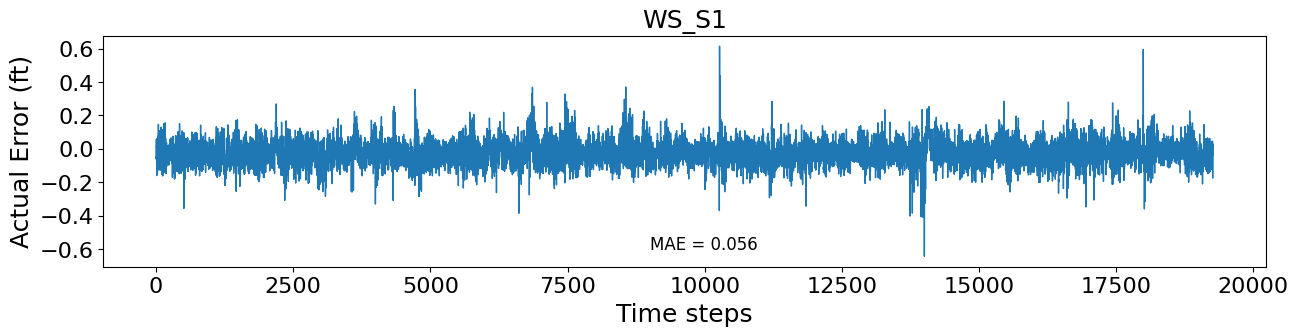

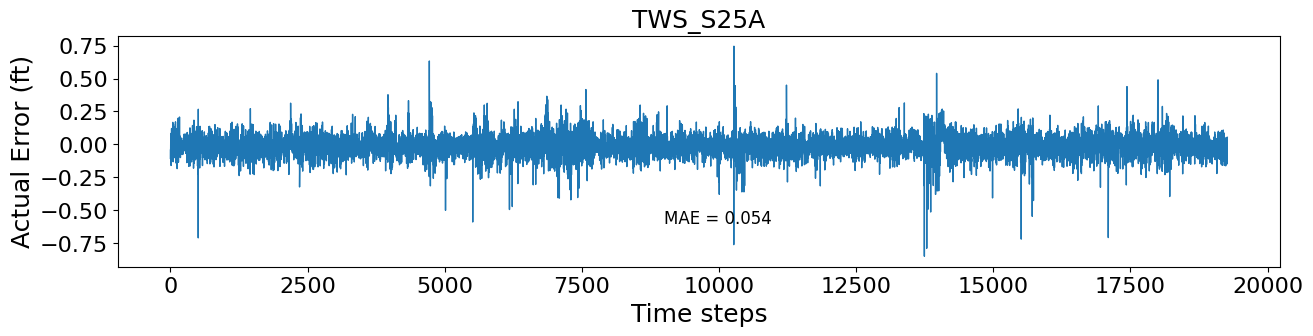

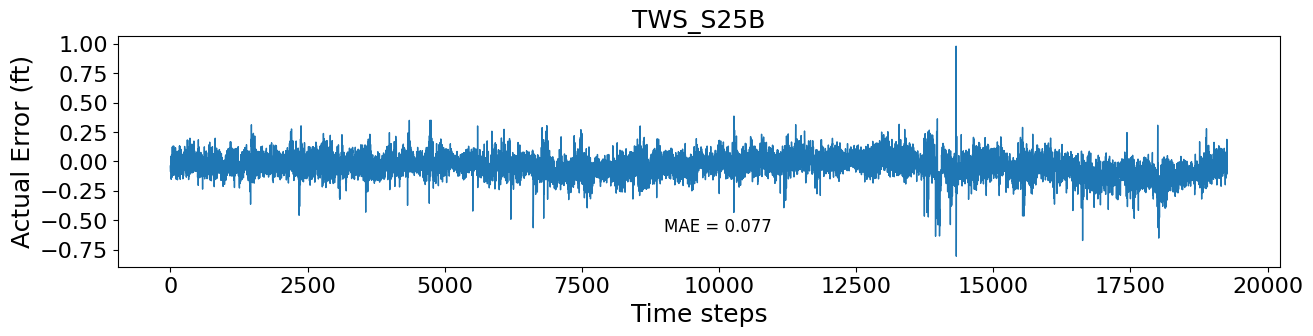

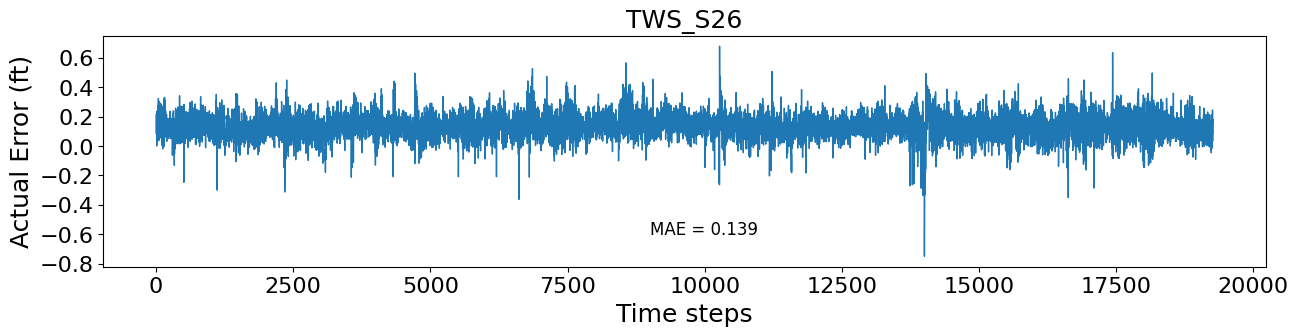

In [12]:
wss = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
inv_yhat_reshape = inv_yhat.reshape((-1, 24, 4))
inv_y_reshape = inv_y.reshape((-1, 24, 4))

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    plt.plot(error[:, -1, i], linewidth=1)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Time steps', fontsize=18)
    plt.ylabel('Actual Error (ft)', fontsize=18)
    plt.title('{}'.format(wss[i]), fontsize=18)
    plt.text(9000, -0.6, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error[:, -1, i]))/len(error)))), fontsize=12)
    plt.show()

In [13]:
up_thre = 0.5
low_thre = -0.5

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre) + np.sum(error[:, -1, i] < low_thre))

(19268,)
4
(19268,)
17
(19268,)
20
(19268,)
11


In [14]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre))

(19268,)
2
(19268,)
5
(19268,)
2
(19268,)
7


In [15]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] < low_thre))

(19268,)
2
(19268,)
12
(19268,)
18
(19268,)
4
